### 0. Import libraries & functions

In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0";
#from pudb import set_trace
import numpy as np
import torch
from torchvision import models

import torch.backends.cudnn as cudnn
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from utils_rb import *
from ramboattack import RamBoAtt
from HSJA_rb import HSJA
from SignOPT_rb import OPT_attack_sign_SGD

In [2]:
def imshow(img):
    
    npimg = img[0].cpu().numpy()
    npimg = np.transpose(npimg,(1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

In [3]:
def perturbation_heat_map(xo,xa):
    
    fig_dims = (5, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    x=torch.abs(xo-xa).sum(dim=1).cpu()[0]
    sns.heatmap(x,ax=ax,xticklabels=False, yticklabels=False,cbar = False)
    plt.show()

### 1. Load data, pretrained model, evaluation set

In [4]:
# a. Load dataset

batch_size = 1
dataset = 'imagenet' # or 'cifar10'
datapath = '../datasets/ImageNet-val'
testloader, testset = load_data(dataset,data_path=datapath,batch_size=batch_size)

In [5]:
# b. Load pre-trained model
arch = 'resnet50' # 'resnet50' if pre-trained model from Pytorch. 'cifar10' if using pre-trained cifar10 model
model_path = None # None means using pre-traineded model from Pytorch. Otherwise, please change model_path = '...'

if dataset == 'cifar10':
    num_classes = 10
    unnorm = True # True means pre-trained model does "not" normalized data while training.
    
elif dataset == 'imagenet':
    num_classes = 1000
    unnorm = False # True means pre-trained model does "not" normalized data while training.

net = load_model(arch,model_path)
model_rb = PretrainedModel(net,dataset,unnorm)

bounds = [0,1]
model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)

In [11]:
# c. Load evaluation set
targeted = True # True means targeted attack. False means untargeted attack.
# 'balance', 'easyset'->imagenet or cifar10; 
# 'hardset'-> imagenet; 
# 'hardset_A','hardset_B','hardset_D' -> cifar10
eval_set =  'balance'#'hardset'

ID_set = get_evalset(dataset,targeted,eval_set)

### 2. HopSkipJump Evaluation

In [22]:
i = 100#8#100#,10 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# ===== 1. select starting image =====
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset):26552#
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
    y_targ = np.array([tlabel])
else:
    tlabel = None
    y_targ = np.array([olabel])
    
# ============= 2. setup ==============
if dataset == 'cifar10':
    delta = 1e-2
    len_T = 500
elif dataset == 'imagenet':
    delta = 1
    len_T = 2000 
constraint='l2'
num_iterations=150
gamma=1.0
stepsize_search='geometric_progression'
max_num_evals = 1e4
init_num_evals=100
verbose=True
auto_terminate=False


In [24]:
model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)
module_1 = HSJA(model_ex,constraint,num_iterations,gamma,stepsize_search,max_num_evals,init_num_evals, verbose,delta,len_T)
if targeted:
    adv, nqry, Dt = module_1.hsja(oimg.cpu().numpy(), y_targ, timg.cpu().numpy(),targeted,query_limit,auto_terminate)
else:
    timg = None
    adv, nqry, Dt = module_1.hsja(oimg.cpu().numpy(), y_targ, timg,targeted,auto_terminate)
    
adv = torch.unsqueeze(torch.from_numpy(adv).float(), 0).cuda()

iteration: 1, l2 distance 6.4961E+01 - nqry:156
iteration: 11, l2 distance 3.8497E+01 - nqry:2921
iteration: 21, l2 distance 3.1400E+01 - nqry:7274
iteration: 31, l2 distance 3.1181E+01 - nqry:12780
iteration: 41, l2 distance 3.0444E+01 - nqry:19212
iteration: 51, l2 distance 2.9365E+01 - nqry:26367
iteration: 61, l2 distance 2.8239E+01 - nqry:34219
iteration: 71, l2 distance 2.2205E+01 - nqry:42685

Break due to over query limit!



Source image:


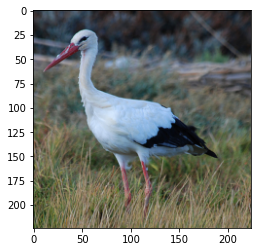

Starting image:


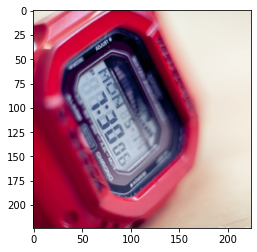

Adversarial Example:


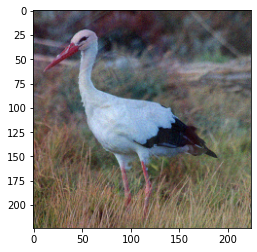

Perturbation Heat Map:


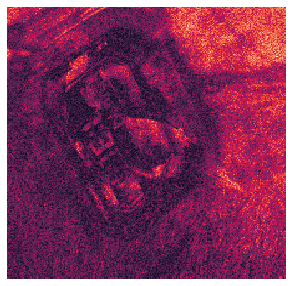

In [25]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [26]:
DHsja = Dt

### 3. Sign-OPT Evaluation

In [27]:
i = 100#8#100#,10 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
    y_targ = np.array([tlabel])
else:
    tlabel = None
    y_targ = np.array([olabel])
    
# ============= 2. setup ==============
alpha = 0.2
beta = 0.001
iterations = 5000
distortion = None
stopping = 0.0001
auto_terminate=False
seed = 0

if dataset == 'cifar10':
    delta = 1e-2
    len_T = 2
elif dataset == 'imagenet':
    delta = 1
    len_T = 4
k=200
module_3 = OPT_attack_sign_SGD(model_rb,k,delta,len_T,testset)

In [28]:
if targeted:
    adv, nqry, Dt = module_3.attack_targeted(oimg, olabel, timg, tlabel, alpha, beta, iterations, query_limit, distortion, seed, stopping, auto_terminate)

Targeted attack - Source: 127 and Target: 531 - pred y0: tensor([127], device='cuda:0') - pred yt: tensor([531], device='cuda:0')
--------> Found distortion 64.8991
==========> Found best distortion 64.8991 in 0.4915 seconds using 24 queries
Iteration   1 distortion 60.5020 num_queries 315
Iteration  11 distortion 38.3097 num_queries 3228
Iteration  21 distortion 31.8260 num_queries 6214
Iteration  31 distortion 29.0777 num_queries 9280
Iteration  41 distortion 26.9596 num_queries 13373
Iteration  51 distortion 26.6607 num_queries 17750
Iteration  61 distortion 25.7149 num_queries 21978
Iteration  71 distortion 24.2329 num_queries 26412
Iteration  81 distortion 23.2442 num_queries 31265
Iteration  91 distortion 22.1518 num_queries 35947
Iteration 101 distortion 21.2663 num_queries 41058
Iteration 111 distortion 20.6490 num_queries 45827
break due to query cnt > query limit 50289

Adversarial Example Found Successfully: distortion 20.2669 target 531 queries 50289 LS queries 26265 
Time:

Source image:


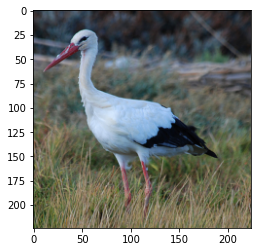

Starting image:


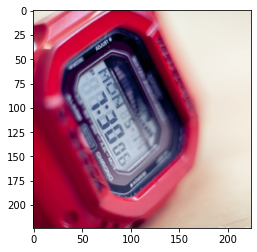

Adversarial Example:


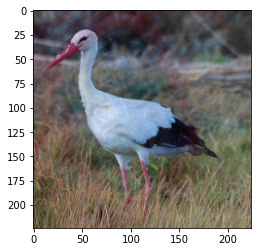

Perturbation Heat Map:


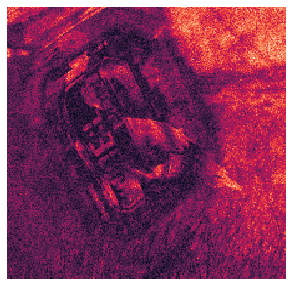

In [29]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [30]:
DSopt = Dt

### 4. RamBoAttack Evaluation

### 4a. RamBoAttack (HSJA) Evaluation

In [31]:
i = 100#8#100#,10 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else:
    tlabel = None

In [32]:
attack_mode = 'RBH' # 'RBH' means RamBoAttack(HSJA) while 'RBS' means RamBoAttack(Sign-OPT) -> see our paper
seed = 0
query_limit = 50000

model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)
module = RamBoAtt(model_rb,model_ex,testset,seed,targeted,dataset)
adv, nqry, Dt = module.hybrid_attack(oimg,olabel,timg,tlabel,query_limit,attack_mode)

iteration: 1, l2 distance 6.2534E+01 - nqry:156
iteration: 11, l2 distance 4.0407E+01 - nqry:2922
iteration: 21, l2 distance 3.3763E+01 - nqry:7283

Break due to slow convergence!

Module 1: Finished HSJA

Qry# 0 ; l2 distance = 33.744449615478516 ; adv label: 531


/home/viet/Documents/GitHub/RamBoAttack/ramboattack.py:39: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  c1 = n // (x.shape[2] * x.shape[3])
/home/viet/Documents/GitHub/RamBoAttack/ramboattack.py:40: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  c2 = (n - c1 * x.shape[2] * x.shape[3])// x.shape[3]


Qry# 1000 ; l2 distance = 31.672178268432617 ; adv label: 531
Qry# 2000 ; l2 distance = 28.769256591796875 ; adv label: 531
Qry# 3000 ; l2 distance = 27.014911651611328 ; adv label: 531
Qry# 4000 ; l2 distance = 25.611574172973633 ; adv label: 531
Qry# 5000 ; l2 distance = 24.010854721069336 ; adv label: 531
Qry# 6000 ; l2 distance = 22.41929817199707 ; adv label: 531
Qry# 7000 ; l2 distance = 20.681997299194336 ; adv label: 531
Qry# 8000 ; l2 distance = 19.23634147644043 ; adv label: 531
Qry# 9000 ; l2 distance = 18.401927947998047 ; adv label: 531
Qry# 10000 ; l2 distance = 17.009050369262695 ; adv label: 531
Qry# 11000 ; l2 distance = 15.402976989746094 ; adv label: 531
Qry# 12000 ; l2 distance = 14.076616287231445 ; adv label: 531
Qry# 13000 ; l2 distance = 13.209151268005371 ; adv label: 531
Qry# 14000 ; l2 distance = 12.243843078613281 ; adv label: 531
Qry# 15000 ; l2 distance = 11.541757583618164 ; adv label: 531
Qry# 16000 ; l2 distance = 10.882567405700684 ; adv label: 531
Qry

Source image:


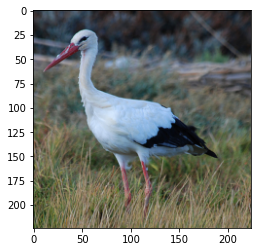

Starting image:


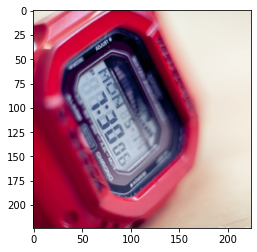

Adversarial Example:


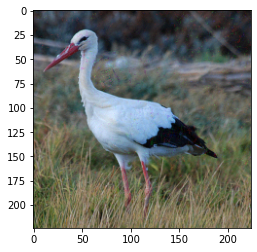

Perturbation Heat Map:


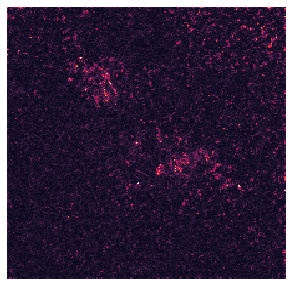

In [33]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [34]:
DRambH = Dt

In [35]:
# check prediction of adversarial example
alabel = model_rb.predict_label(adv).item()
dist = torch.norm(adv-oimg)
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L2 dist:{dist}')

- sample ID: 6384
- ground-truth: 127 
- target label: 531 
- AdvEx label: 531
- L2 dist:5.466150760650635


### 4b. RamBoAttack (SignOPT) Evaluation

In [36]:
i = 100#8#100#,10 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else:
    tlabel = None

In [37]:
attack_mode = 'RBS' # 'RBH' means RamBoAttack(HSJA) while 'RBS' means RamBoAttack(Sign-OPT) -> see our paper
seed = 0
query_limit = 50000
module = RamBoAtt(model_rb,model_ex,testset,seed,targeted,dataset)
adv, nqry, Dt = module.hybrid_attack(oimg,olabel,timg,tlabel,query_limit,attack_mode)

Targeted attack - Source: 127 and Target: 531 - pred y0: tensor([127], device='cuda:0') - pred yt: tensor([531], device='cuda:0')
--------> Found distortion 64.8991
==========> Found best distortion 64.8991 in 1.2365 seconds using 24 queries
Iteration   1 distortion 60.5020 num_queries 315
Iteration  11 distortion 38.3097 num_queries 3228
Iteration  21 distortion 31.8260 num_queries 6214

 break due to slow convergence and group dim = 1!


Adversarial Example Found Successfully: distortion 29.9247 target 531 queries 8624 LS queries 2800 
Time: 792.0953 seconds
Module 1: Finished SignOPT

Qry# 0 ; l2 distance = 29.924697875976562 ; adv label: 531
Qry# 1000 ; l2 distance = 28.231664657592773 ; adv label: 531
Qry# 2000 ; l2 distance = 26.19800567626953 ; adv label: 531
Qry# 3000 ; l2 distance = 24.023950576782227 ; adv label: 531
Qry# 4000 ; l2 distance = 22.377744674682617 ; adv label: 531
Qry# 5000 ; l2 distance = 20.9114990234375 ; adv label: 531
Qry# 6000 ; l2 distance = 19.7020416259

Source image:


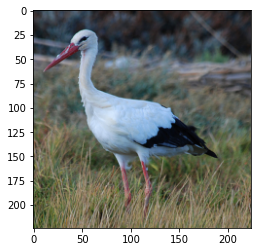

Starting image:


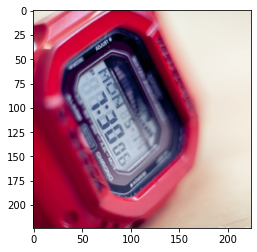

Adversarial Example:


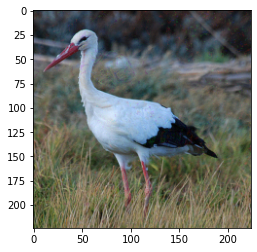

Perturbation Heat Map:


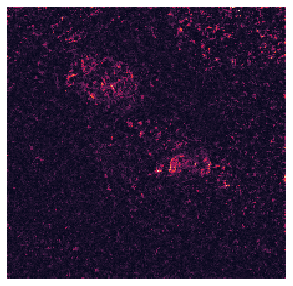

In [38]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [39]:
DRambS = Dt

In [40]:
# check prediction of adversarial example
alabel = model_rb.predict_label(adv).item()
dist = torch.norm(adv-oimg)
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L2 dist:{dist}')

- sample ID: 6384
- ground-truth: 127 
- target label: 531 
- AdvEx label: 531
- L2 dist:4.930771827697754


### 6. Plot Distortion vs Queries

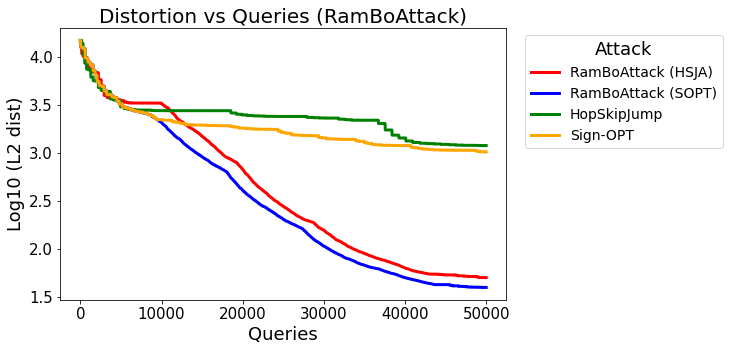

In [41]:
nq = query_limit
q = np.arange(nq)
df = pd.DataFrame({'qry':q,'dRambH':np.log(DRambH[:query_limit]),
                   'dRambS':np.log(DRambS[:query_limit]),
                   'dHsja':np.log(DHsja[:query_limit]),
                  'dSopt':np.log(DSopt[:query_limit])})

fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
f = sns.lineplot(x = 'qry', y = 'dRambH',ax=ax,linewidth = 3, color = 'red',label = 'RamBoAttack (HSJA)',data=df)
f = sns.lineplot(x = 'qry', y = 'dRambS',ax=ax,linewidth = 3, color = 'blue',label = 'RamBoAttack (SOPT)',data=df)
f = sns.lineplot(x = 'qry', y = 'dHsja',ax=ax,linewidth = 3, color = 'green',label = 'HopSkipJump',data=df)
f = sns.lineplot(x = 'qry', y = 'dSopt',ax=ax,linewidth = 3, color = 'orange',label = 'Sign-OPT',data=df)

f.axes.set_title("Distortion vs Queries (RamBoAttack)",fontsize=20)
f.set_xlabel("Queries",fontsize=18)
f.set_ylabel("Log10 (L2 dist)",fontsize=18)
f.tick_params(labelsize=15)
#plt.legend(labels=['RamBoAttack (HSJA)'])
plt.legend(title='Attack', fontsize='14', title_fontsize='18',bbox_to_anchor= (1.5,1))
plt.show()